In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

In [4]:
DtoP = np.load('DtoP_transition_matrix.npy')
PtoE = np.load('PtoE_transition_matrix.npy')
EtoM = np.load('EtoM_transition_matrix.npy')
MtoD = np.load('MtoD_transition_matrix.npy')

In [5]:
def plot_matrix_cell_evolution(matrices, ffit=None):
    """
    Plot the evolution of each cell in a series of 5x5 matrices over time.
    
    Parameters:
    matrices (list of np.ndarray): A list of four 5x5 numpy arrays representing values at four timepoints.
    """
    assert len(matrices) == 4, "Input must be a list of four 5x5 matrices"
    for mat in matrices:
        assert mat.shape == (5, 5), "All matrices must be 5x5"

    fig, axes = plt.subplots(5, 5, figsize=(8,8), dpi=300, sharex=True, sharey=True)
    fig.suptitle("Probability evolution over estrous cycle")

    timepoints = np.arange(4)
    timepoints_f = np.arange(0,3.2,0.2)

    symbol_matrix = np.array([
        [r'$\delta_M$', r'$\gamma_{M \to F}$', r'$\gamma_{M \to H}$', r'$\gamma_{M \to S}$', r'$-\lambda_M$'],
        [r'$\delta_S$', r'$\gamma_{S \to F}$', r'$\gamma_{S \to H}$', r'$-\lambda_S$', r'$\gamma_{S \to M}$'],
        [r'$\delta_H$', r'$\gamma_{H \to F}$', r'$-\lambda_H$', r'$\gamma_{H \to S}$', r'$\gamma_{H \to M}$'],
        [r'$\delta_F$', r'$-\lambda_F$', r'$\gamma_{F \to H}$', r'$\gamma_{F \to S}$', r'$\gamma_{F \to M}$'],
        [r'$0$', r'$\beta_F$', r'$\beta_H$', r'$\beta_S$', r'$\beta_M$']
    ])

    for i in range(5):
        for j in range(5):
            values = [mat[i, j] for mat in matrices]
            ax = axes[i, j]
            ax.plot(timepoints, values, marker='.', color='k')
            if ffit is not None:
                fit_over_finer_grid = np.interp(timepoints_f, np.arange(4), ffit[:, i, j])
                ax.plot(timepoints_f, fit_over_finer_grid, marker='x', color='tab:orange')
            ax.set_title(symbol_matrix[i,j])
            if j == 0:
                ax.set_ylabel('$P$')
            ax.set_xticks(range(4), labels=['D','P','E','M'])
            ax.set_xlim([-0.5,3.5])
    plt.tight_layout()
    plt.show()
    # fig.savefig('probability_evolution_over_cycle.svg')

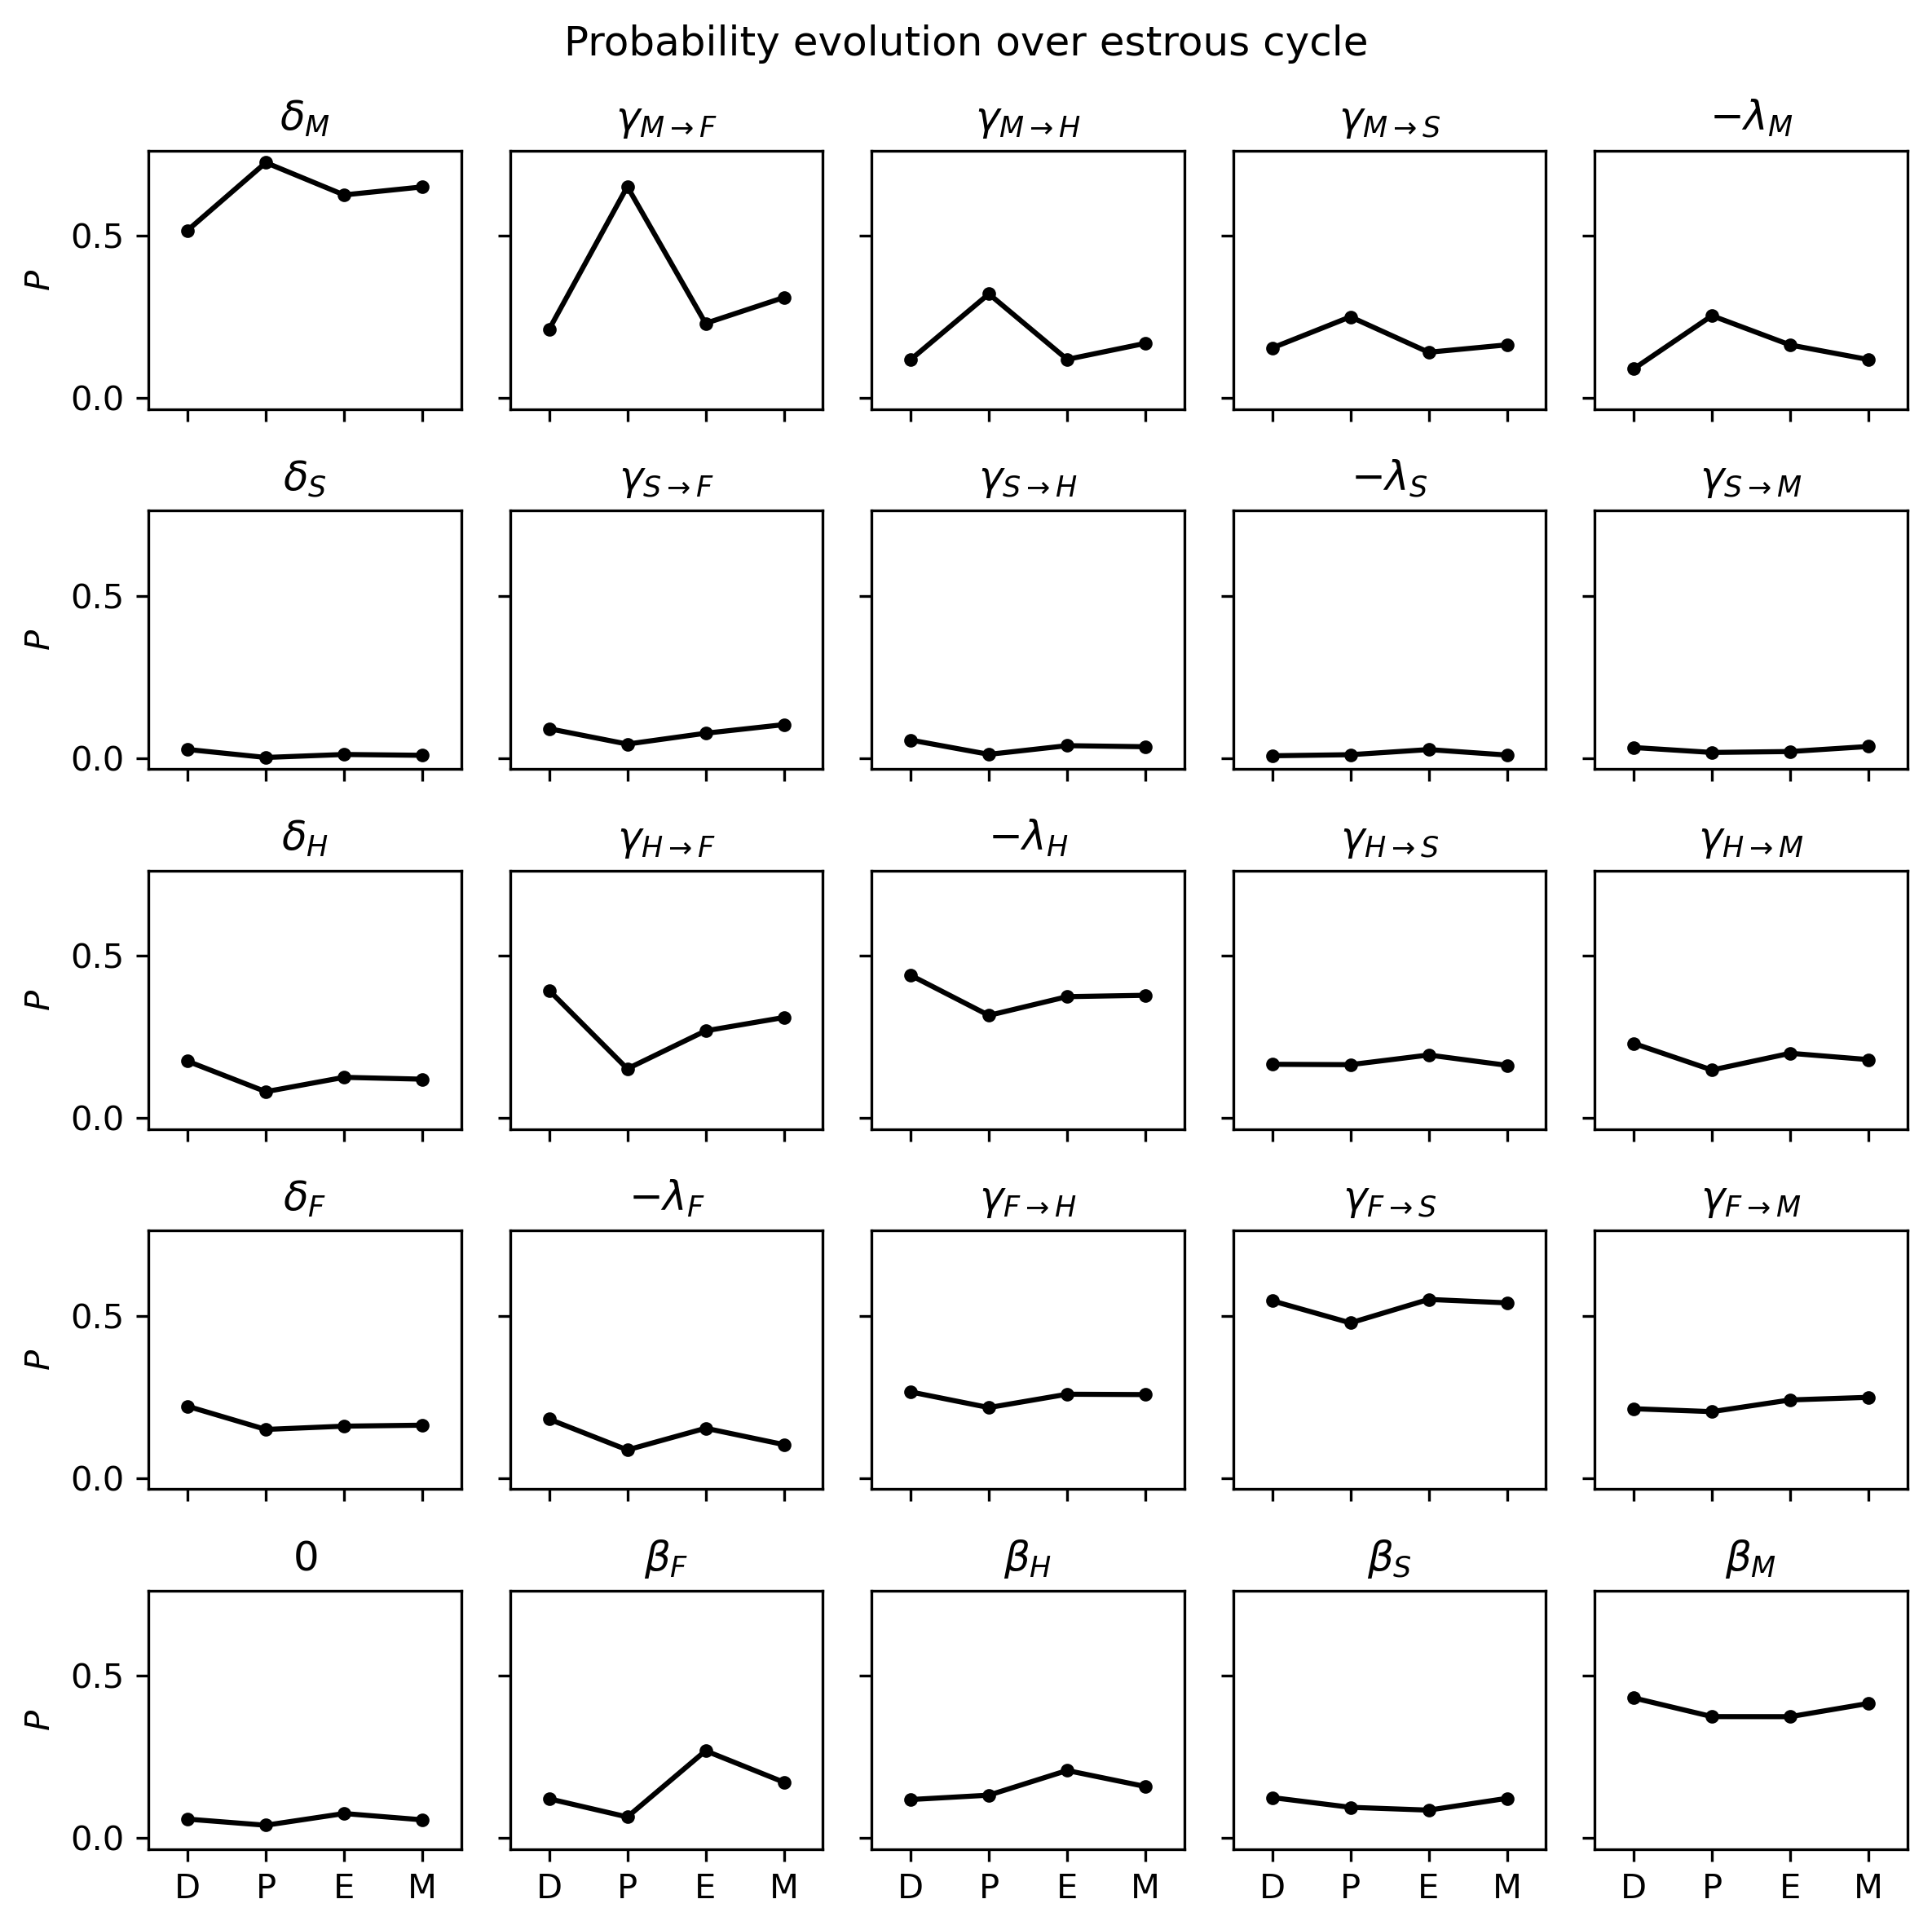

In [6]:
plot_matrix_cell_evolution([DtoP,PtoE,EtoM,MtoD])

/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_31813/976884012.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, num_values))
/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_31813/976884012.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


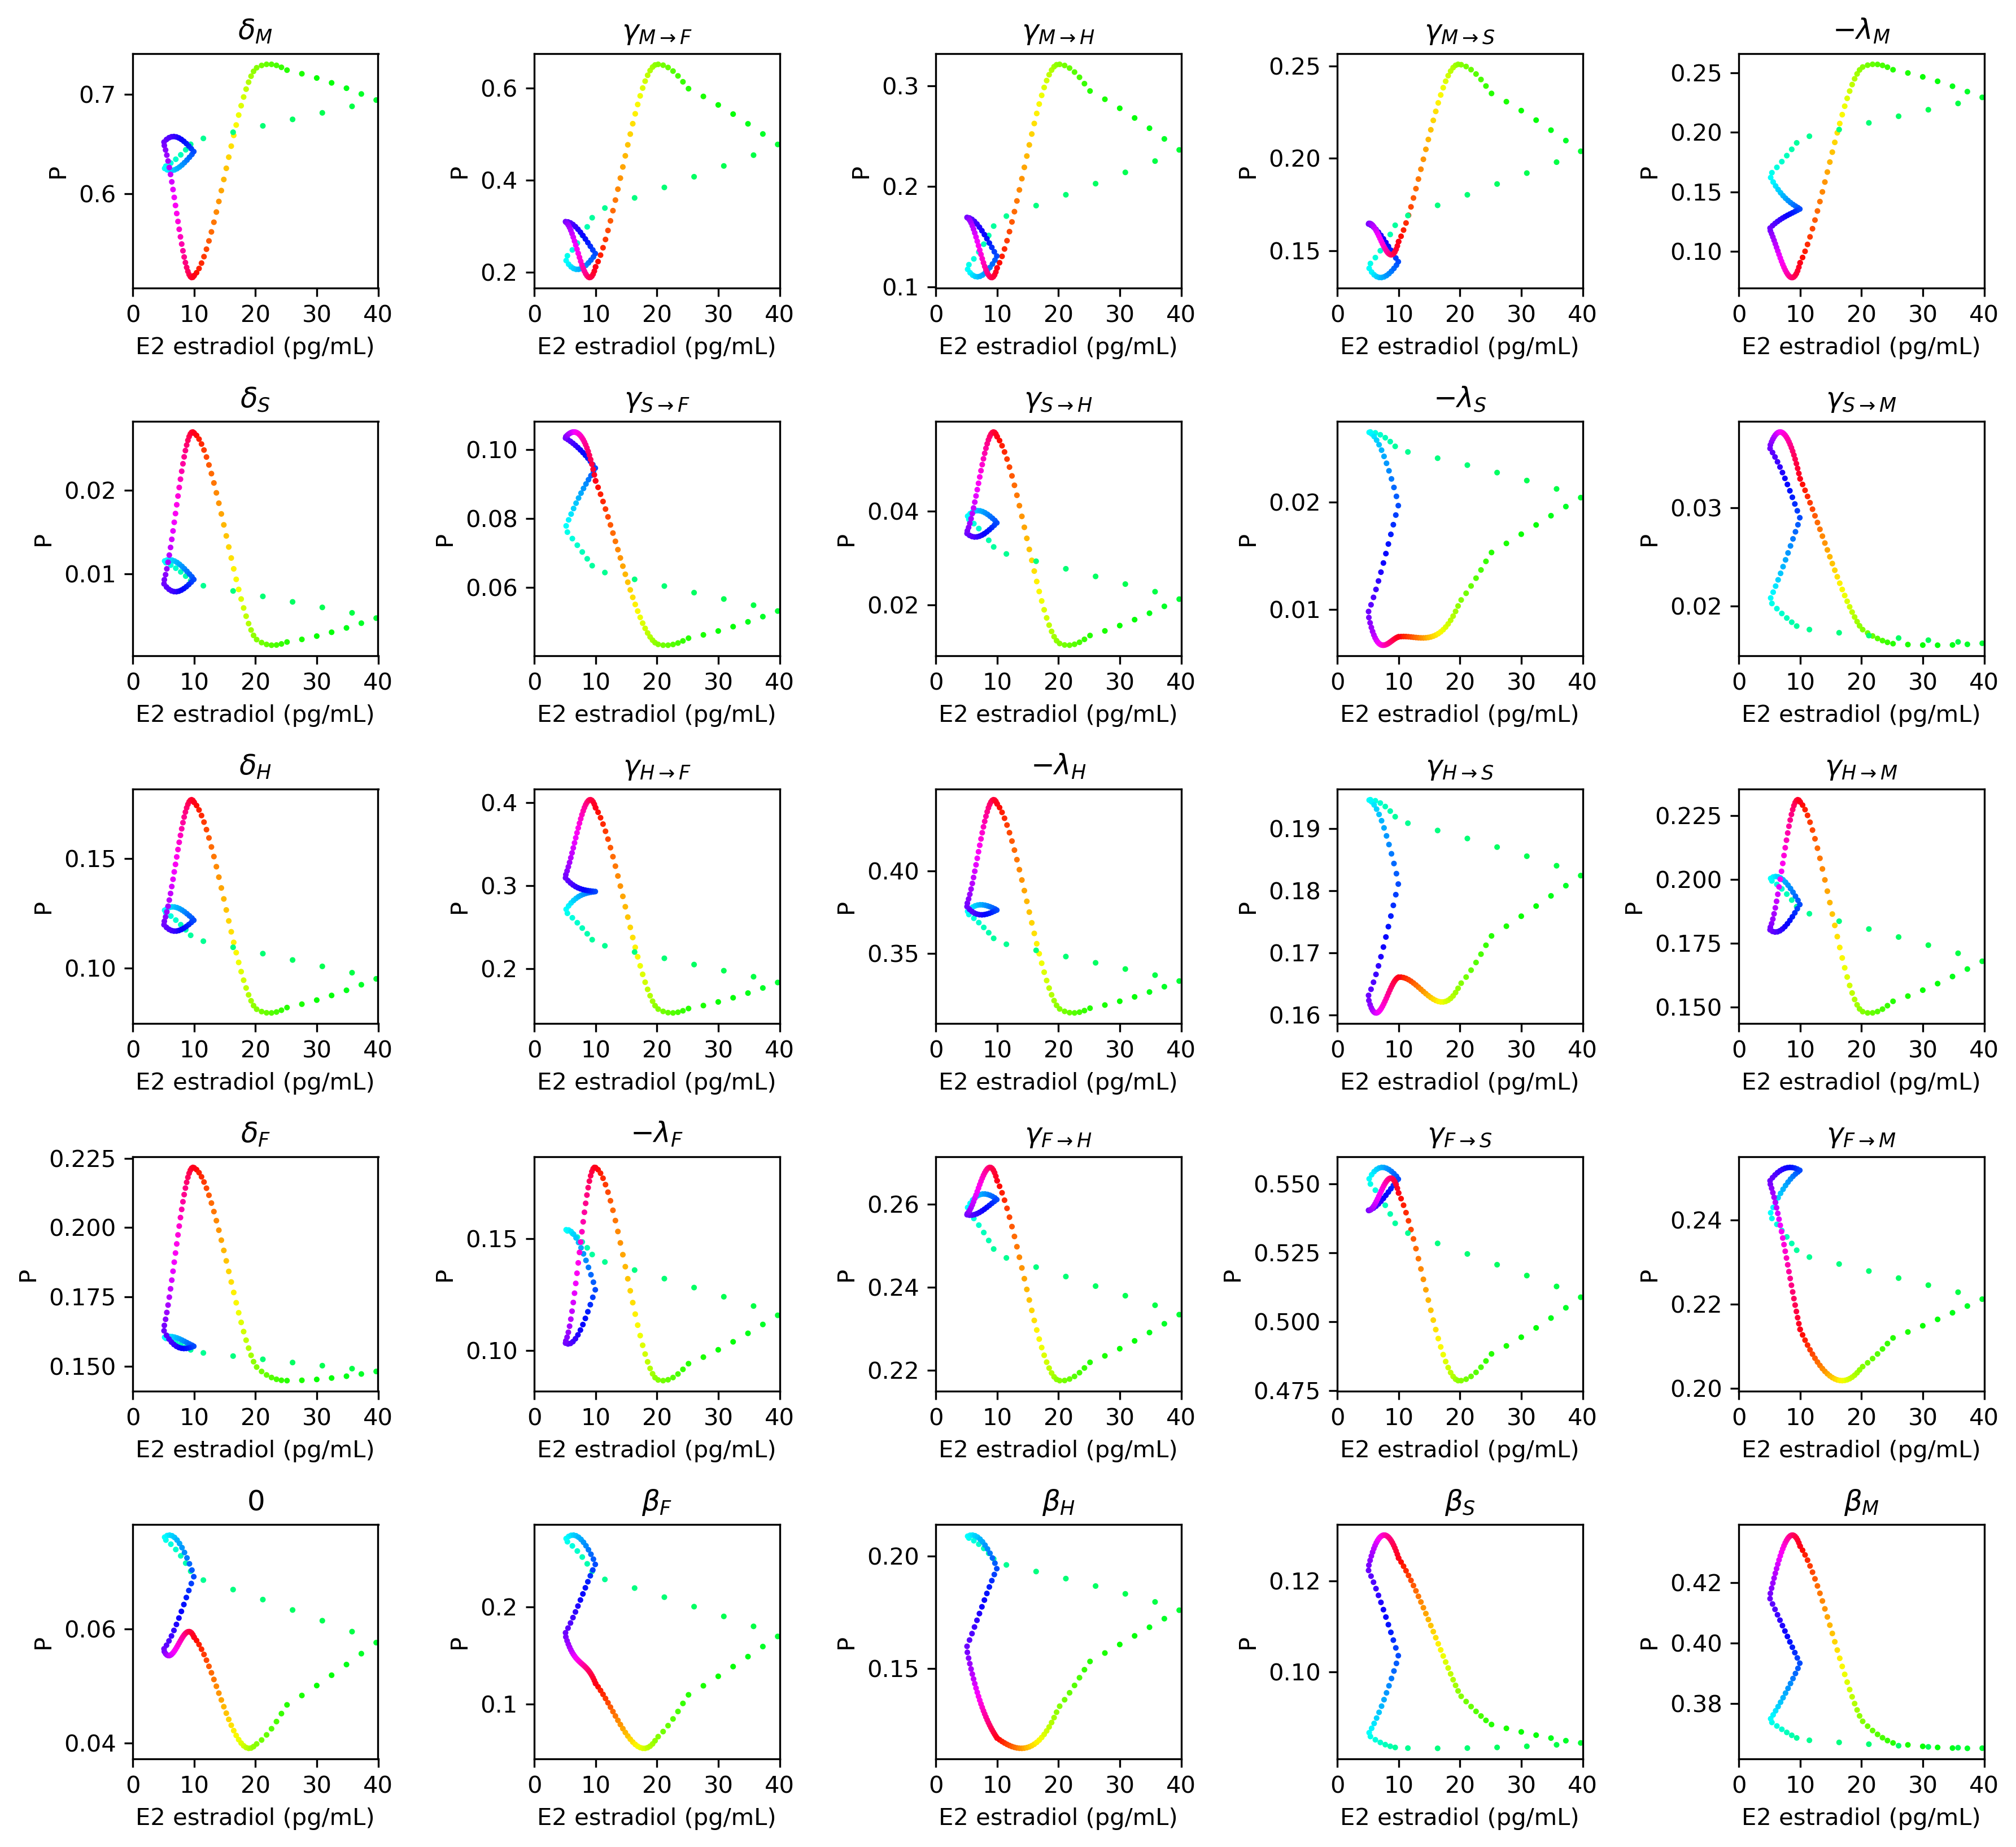

In [75]:
def plot_transition_vs_E2(matrices):

    num_values = 100

    assert len(matrices) == 4, "Input must be a list of four 5x5 matrices"
    for mat in matrices:
        assert mat.shape == (5, 5), "All matrices must be 5x5"

    fig, axes = plt.subplots(5, 5, figsize=(12,11), dpi=300)#, sharex=True, sharey=True)
    # fig.suptitle("Probability evolution over estrous cycle")

    x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
    y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
    estradiol_level = np.interp(np.linspace(0,4,num_values)*24, x_data*24, y_data)
    timepoints_f = np.linspace(0,4,num_values)*24

    symbol_matrix = np.array([
        [r'$\delta_M$', r'$\gamma_{M \to F}$', r'$\gamma_{M \to H}$', r'$\gamma_{M \to S}$', r'$-\lambda_M$'],
        [r'$\delta_S$', r'$\gamma_{S \to F}$', r'$\gamma_{S \to H}$', r'$-\lambda_S$', r'$\gamma_{S \to M}$'],
        [r'$\delta_H$', r'$\gamma_{H \to F}$', r'$-\lambda_H$', r'$\gamma_{H \to S}$', r'$\gamma_{H \to M}$'],
        [r'$\delta_F$', r'$-\lambda_F$', r'$\gamma_{F \to H}$', r'$\gamma_{F \to S}$', r'$\gamma_{F \to M}$'],
        [r'$0$', r'$\beta_F$', r'$\beta_H$', r'$\beta_S$', r'$\beta_M$']
    ])
    
    new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, num_values))

    for i in range(5):
        for j in range(5):
            values = [mat[i, j] for mat in matrices]
            ax = axes[i,j]

            # linear interpolation
            # fit_over_finer_grid = np.interp(timepoints_f, np.arange(4)*24, values)

            # circular interpolation
            x_ = np.arange(5)*24
            y_ = np.append(values, values[0])
            spline_interp = scipy.interpolate.CubicSpline(x_, y_, bc_type="periodic")
            fit_over_finer_grid = spline_interp(timepoints_f)

            # if i==0 and j==0:
            #     print(timepoints_f, fit_over_finer_grid)
            ax.scatter(estradiol_level[np.arange(num_values)], fit_over_finer_grid, s=2, color=new_colors)
            # ax.plot(timepoints, values, marker='.', color='k')
            ax.set_title(symbol_matrix[i,j])
            # if j == 0:
                # ax.set_ylabel('$P$')
            # ax.set_xticks(range(4), labels=['D','P','E','M'])
            ax.set_xlim([0,40])
            ax.set_xticks(np.arange(0,50,10))
            ax.set_xlabel('E2 estradiol (pg/mL)')
            ax.set_ylabel('P')

    fig.tight_layout()
    fig.show()
        # fig.savefig('probability_evolution_over_cycle.svg')

plot_transition_vs_E2([DtoP,PtoE,EtoM,MtoD])


/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_31813/2287581208.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, 100))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

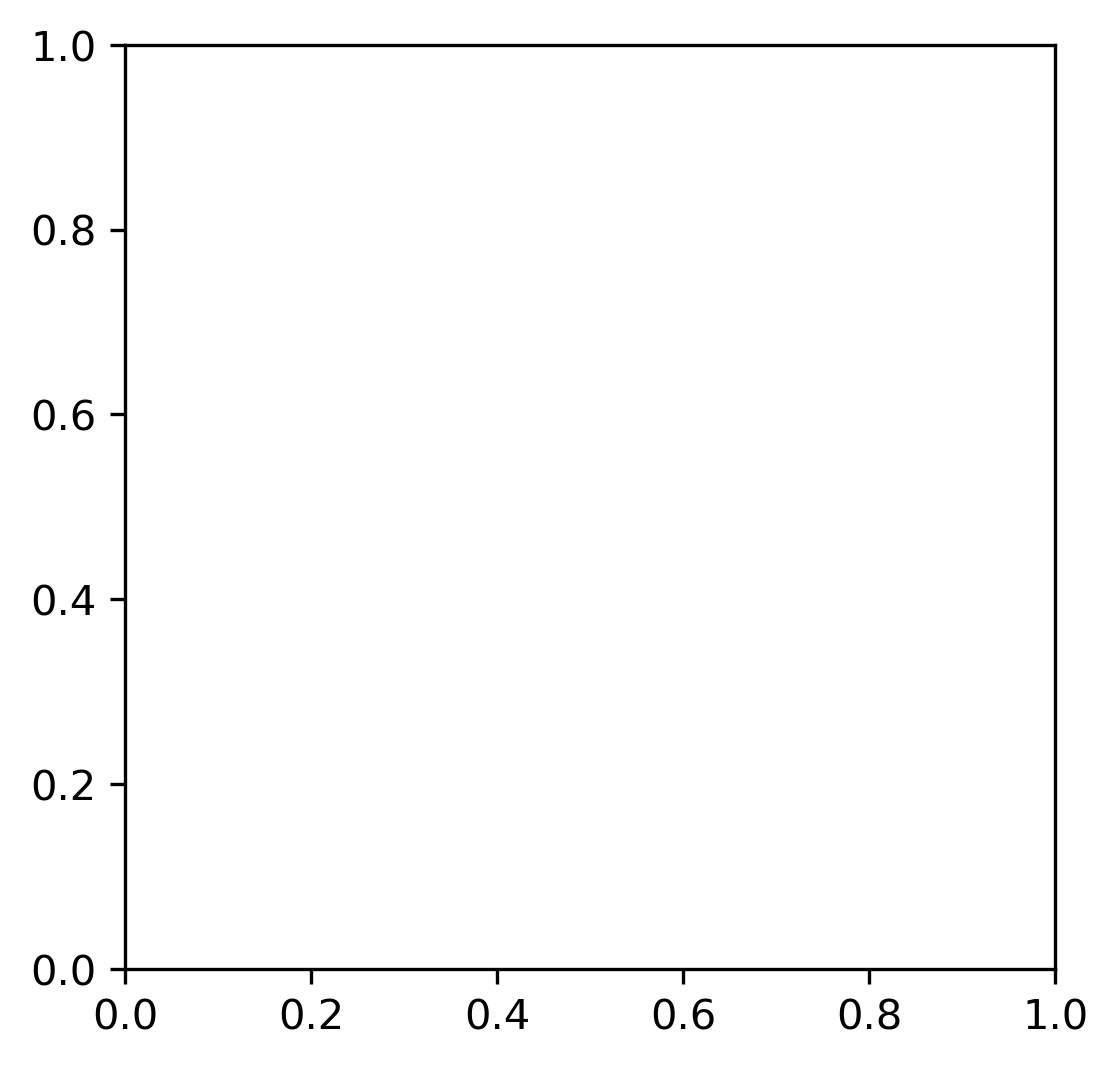

In [79]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4,4))
new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, 100))
sm = plt.cm.ScalarMappable(cmap='hsv')
cbar = fig.colorbar(sm)

In [71]:
np.arange(5)*24

array([ 0, 24, 48, 72, 96])

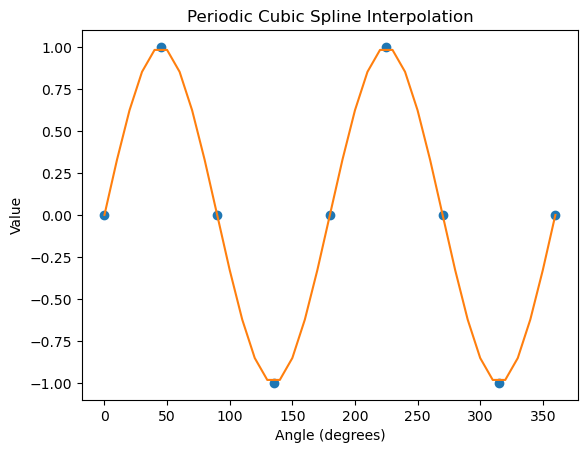

In [61]:
import numpy as np
import scipy.interpolate

# Sample cyclical data (assuming x is angle in degrees and y is some value)
x = np.array([0, 45, 90, 135, 180, 225, 270, 315, 360])
y = np.array([0, 1, 0, -1, 0, 1, 0, -1, 0])

# Create a periodic cubic spline
spline = scipy.interpolate.CubicSpline(x, y, bc_type="periodic")

# Interpolate at a new set of points (e.g., every 10 degrees)
x_new = np.arange(0, 360 + 1, 10)
y_new = spline(x_new)

# Plot the original data and the interpolated curve
import matplotlib.pyplot as plt
plt.plot(x, y, 'o')
plt.plot(x_new, y_new)
plt.title("Periodic Cubic Spline Interpolation")
plt.xlabel("Angle (degrees)")
plt.ylabel("Value")
plt.show()

In [43]:
x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
estradiol_level = np.interp(np.linspace(0,4,100)*24, x_data*24, y_data)

array([ 0, 10, 20, 30, 40])

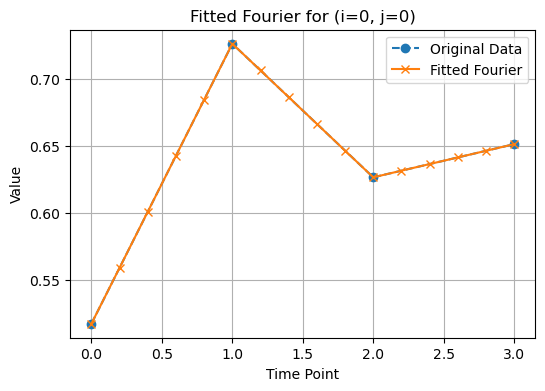

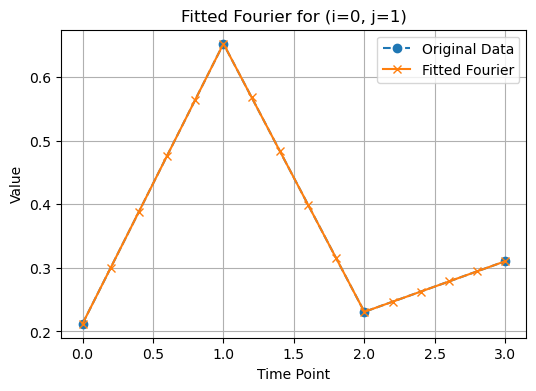

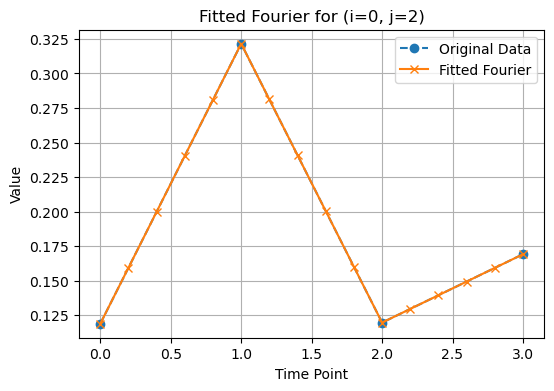

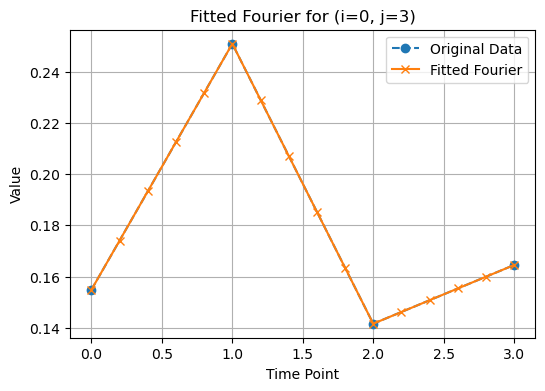

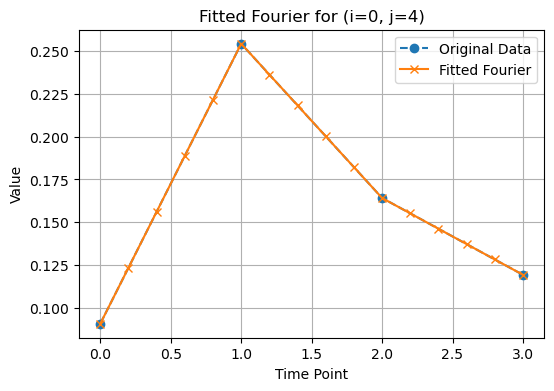

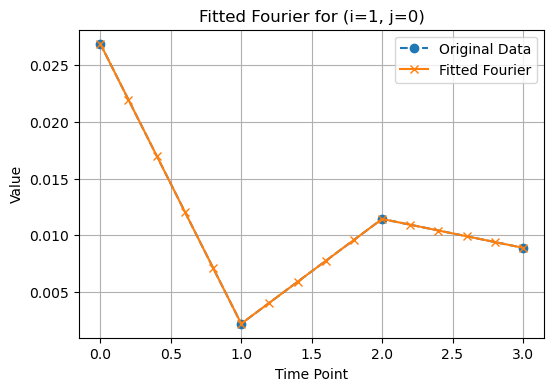

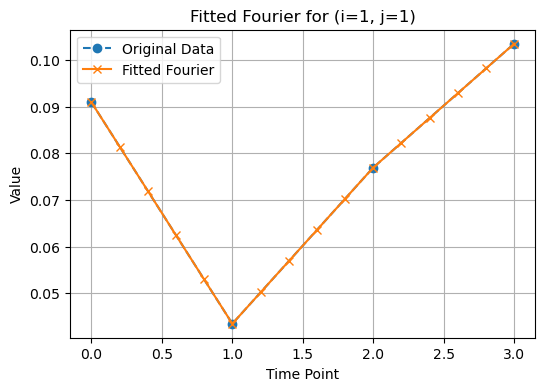

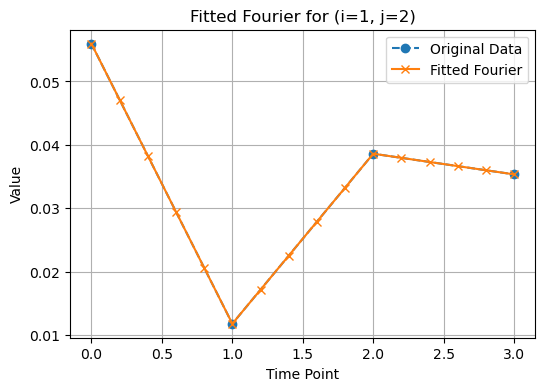

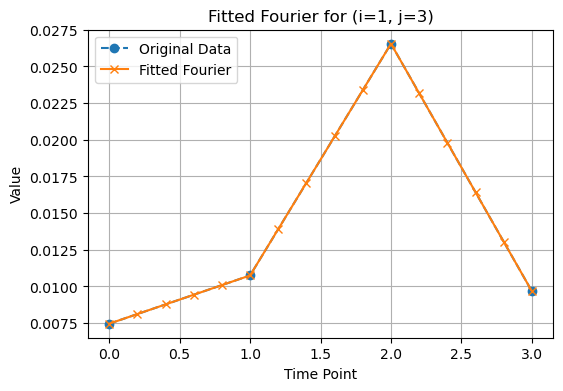

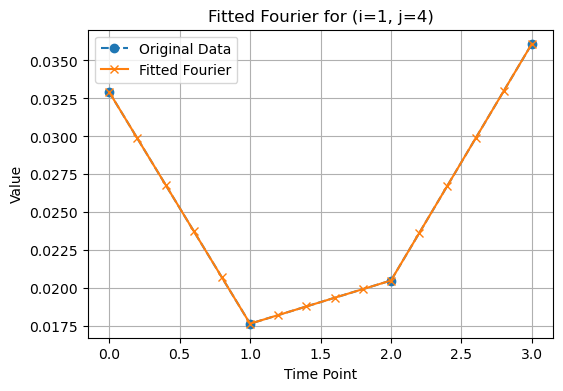

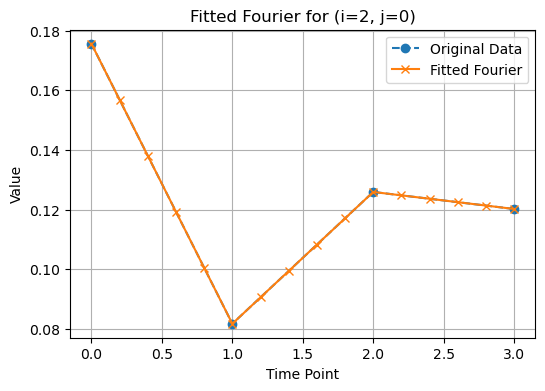

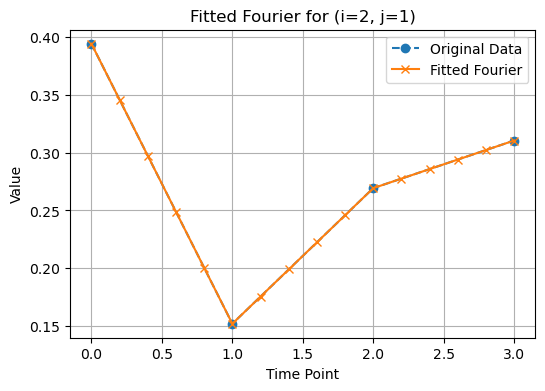

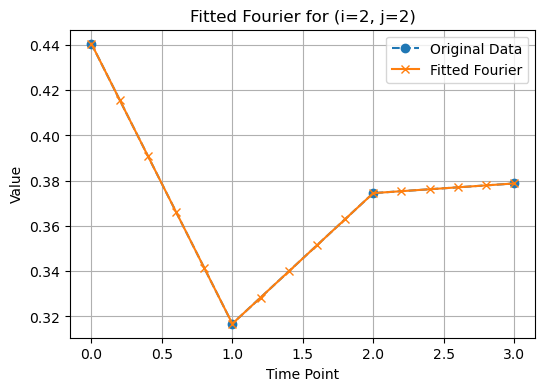

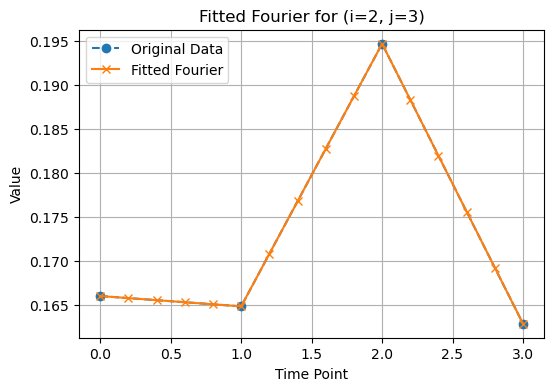

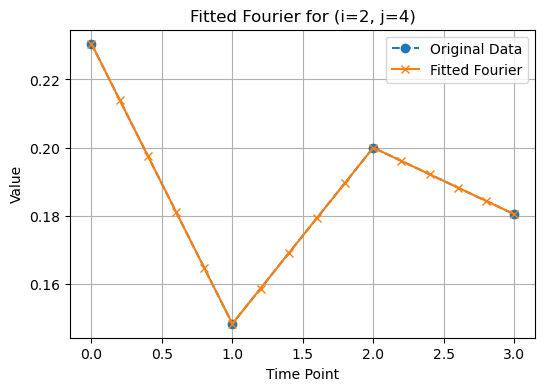

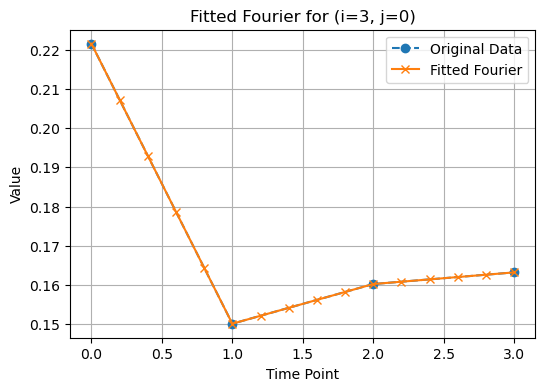

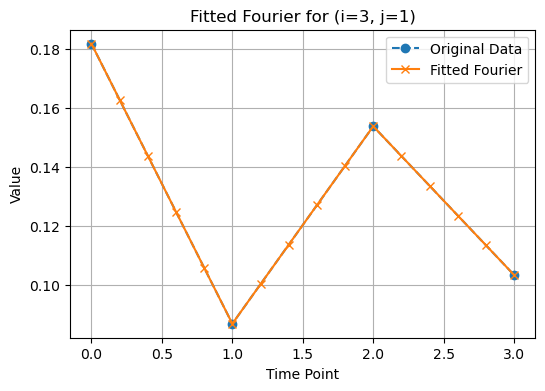

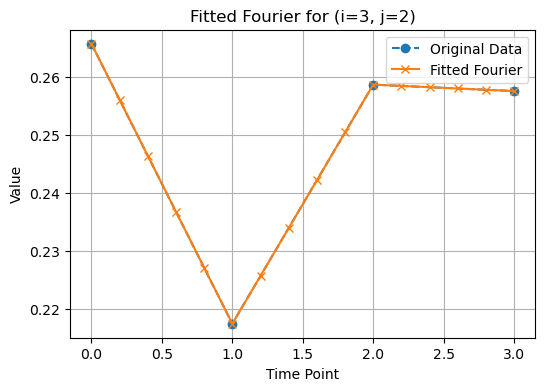

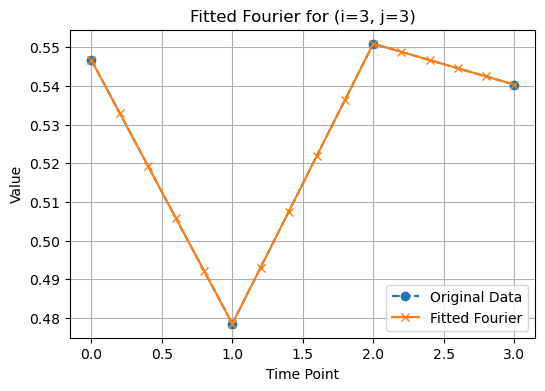

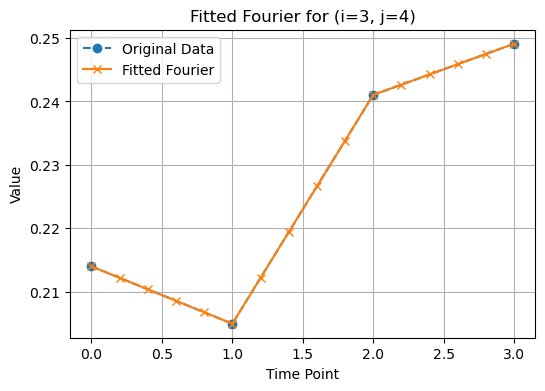

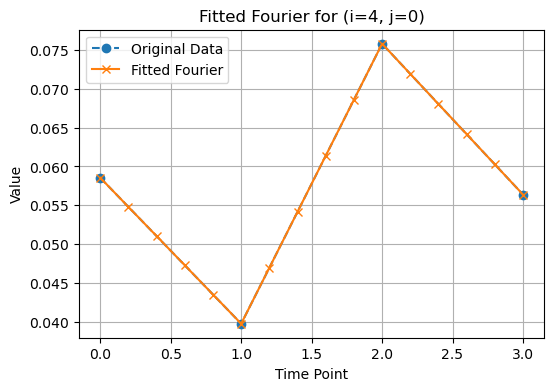

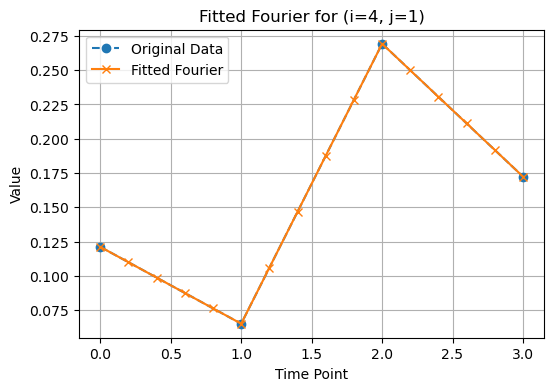

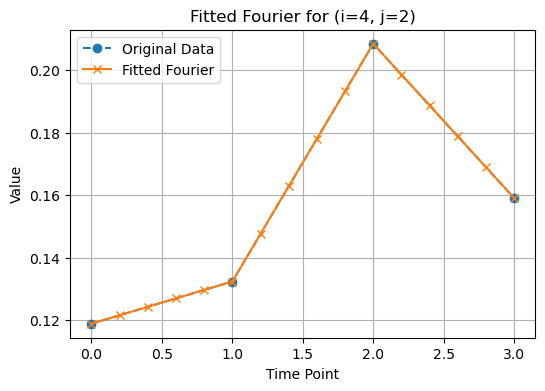

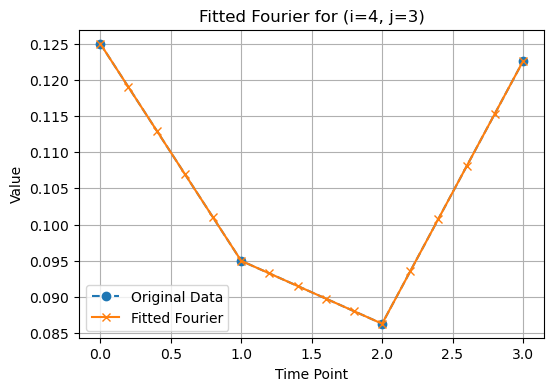

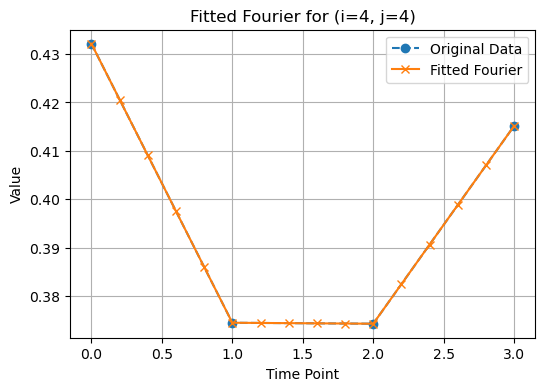

In [41]:
data = np.array([DtoP,PtoE,EtoM,MtoD])

def fit_fourier(data, num_harmonics=1):
    """
    Fit a Fourier function to the data for each position (i,j).
    data is a 4x5x5 numpy array where each matrix represents the data at each time point.

    Args:
        data (numpy array): 4x5x5 array with the data at 4 time points for each (i,j).
        num_harmonics (int): Number of harmonics to use in the Fourier fit.

    Returns:
        fit_results (numpy array): Fitted Fourier components for each (i,j).
    """
    # Prepare time axis (4 time points)
    time_points = np.array([0, 1, 2, 3])

    # Array to store the Fourier fit results
    fit_results = np.zeros_like(data)

    # Loop over each (i, j) position
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            # Extract the 4 time-point data for the (i, j) position
            y = data[:, i, j]

            # Perform Fourier Transform on the data
            y_fft = fft(y)

            # Only keep the first num_harmonics components (ignoring higher frequencies)
            y_fft[num_harmonics+1:] = 0  # Zero out higher frequencies

            # Reconstruct the data using inverse FFT
            y_fit = np.real(ifft(y_fft))

            # Store the fitted result back into the array
            fit_results[:, i, j] = y_fit

    return fit_results

# Fit the Fourier function to the data
fitted_data = fit_fourier(data, num_harmonics=3)

new_time_points = np.arange(0, 3.2, 0.2)

# Plot the original data vs the fitted data on the finer time grid for each (i, j)
for i in range(5):  # Loop through the rows
    for j in range(5):  # Loop through the columns
        # Extract the original 4 time-point data for the (i, j) position
        original_data = data[:, i, j]

        # Create a finer grid using interpolation
        # Generate the Fourier fit over the finer timepoints
        fit_over_finer_grid = np.interp(new_time_points, np.arange(4), fitted_data[:, i, j])

        # Plot original data and fitted curve
        plt.figure(figsize=(6, 4))
        plt.plot(np.arange(4), original_data, label='Original Data', marker='o', linestyle='--')
        plt.plot(new_time_points, fit_over_finer_grid, label='Fitted Fourier', marker='x', linestyle='-')
        plt.title(f'Fitted Fourier for (i={i}, j={j})')
        plt.xlabel('Time Point')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()